# Utilisation de réseaux de neuronnes profonds et de convolutions pour la classification d'images

L'objectif de ce notebook est de comparer différentes architectures afin d'obtenir le meilleur score prossible de prédiction sur le dataset MNIST dans le cadre de la compétition Kaggle associée.
La librairie utilisée est Keras.

Meilleur score final obtenu: accuracy données test 0.99757 pour 138,682 parametres. TOP 4% Kaggle

In [3]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Activation, Flatten, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

Import et traitemment du jeu de données

In [11]:
#Depuis le dataset MNIST de Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n_cols=X_train.shape[1]*X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_cols)
X_test = X_test.reshape(X_test.shape[0], n_cols)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
X_train=X_train/255
X_test=X_test/255
taille_batch=20
lr=[0.000001,0.01,1] #different lr à tester
early_stopping = EarlyStopping(patience=2)

#Depuis le dataset fourni par Kaggle
data_train_kaggle=pd.read_csv("/Users/nathanredin/Downloads/digit-recognizer/train.csv")
data_train_kaggle=np.array(data_train_kaggle)
data_test_kaggle=pd.read_csv("/Users/nathanredin/Downloads/digit-recognizer/test.csv")
data_test_kaggle=np.array(data_test_kaggle)
X_test_kaggle=data_test_kaggle.reshape(28000,28,28,1)
y_train_kaggle=data_train_kaggle[:,0]
X_train_kaggle=data_train_kaggle[:,1:42000]
X_train_kaggle=X_train_kaggle.reshape(42000,28,28,1)
y_train_kaggle = np_utils.to_categorical(y_train_kaggle, 10)
X_train_kaggle=X_train_kaggle/255
X_test_kaggle=X_test_kaggle/255


#nb: j'ai utilisé l'intégralité du dataset MNIST pour entrainer les models:
#X_train = np.concatenate((X_train, X_test))
#y_train = np.concatenate((y_train, y_test))

Comme nous allons entrainer plusieurs fois le même model et pour la lisibilité de ce notebook,
je crée une fonction réinitialisant les poids du model

In [7]:
def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

## Creation d'un reseau basique (type RBM) et entrainement sur les données d'apprentissage:


In [4]:
model = Sequential()
#premiere couche
model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
#seconde couche
model.add(Dense(50, activation='relu'))
#derniere couche
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 27,280
Trainable params: 27,280
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, batch_size=taille_batch,epochs=10)
model.evaluate(X_test,y_test)

## Réseau à convolutions (CNN)

In [9]:
X_train=X_train.reshape(60000,28,28,1)    #l'entrée d'une couche de convolutions doit etre en format matriciel (ici 28x28)
img_rows=X_train.shape[1]
img_cols=X_train.shape[2]

# Initialisation du model
model = Sequential()

# ajout d'une convolution:
model.add(Conv2D(10, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1]))
#pour réduire le temps de calcule et la qualité du modele on peut jouer sur le padding et le strides ou encore utiliser un noyau dilaté...

#ajout d'un MaxPooling pour réduire le nombres de parametres

model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

model.add(Conv2D(10, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1]))

# applatissage et concaténation des features map
model.add(Flatten())

#premiere couche
model.add(Dense(32, activation='relu', input_shape = (n_cols,)))
#seconde couche
model.add(Dense(50, activation='relu'))
#derniere couche
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 10)        910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1210)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                38752     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1650      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total para

In [ ]:
model.fit(X_train, y_train, batch_size=taille_batch,epochs=10)
model.evaluate(X_test,y_test)

Avec cette architecture, je me retrouve classé top 29% seulement alors qu'on a une accuracy de 99.9% sur les données d'apprentissage, contre 99.3114% sur les données test (sans le maxpool et le second cnn), et 98.8871% avec. Je soupçonne donc un leger overfitting.


# Afin d'éviter l'overfitting: 

On peut deja commencer par plot la validation-loss curve selon le nombre d'epochs effectués afin d'avoir une idée de l'évolution du model durant la phase d'apprentissage:

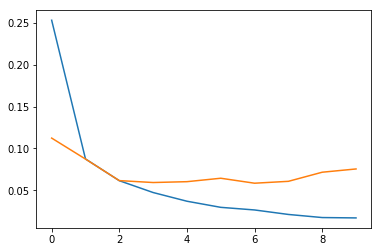

In [9]:
reset_weights(model)
training = model.fit(X_train, y_train, batch_size=taille_batch,epochs=10,verbose=0,validation_split=0.2)
history = training.history
plt.plot(history['loss'])
# Plot the validation loss
plt.plot(history['val_loss'])
# Show the figure
plt.show()

On observe que rapidement (après 4 à 5 epochs) la valeur de l'entropie croisée sur les données test stagne et ré-augmente. C'est donc qu'il y a overfiting.

Plusieurs solution:

## Ajouter un callback dans le model.fit

In [10]:
reset_weights(model)

early_stopping = EarlyStopping(patience=2)
training = model.fit(X_train, y_train, batch_size=taille_batch,epochs=10,callbacks=[early_stopping],validation_split=0.2)

yo


## Stocker les poids après chaque training et recuperer ceux qui minimisent la val_loss grace à la methode Callback de Keras


In [ ]:
reset_weights(model)

checkpoint=ModelCheckpoint('weights.hdf5',monitor='val_loss',save_best_only=True) #a executer avant l'apprentissage
callback_list=[checkpoint]
training = model.fit(X_train, y_train, batch_size=taille_batch,epochs=10,callbacks=callback_list,validation_split=0.2)

model.load_weights('weights.hdf5')

## Régularisation par ajout d'une couche dropout et batch normalization

In [13]:

x_train=X_train.reshape(70000,28,28,1)
img_rows=x_train.shape[1]
img_cols=x_train.shape[2]

#le nombre de parametres étant réduit par les 2 couches de MaxPooling et le Dropout, on peut augmenter le nombre de noyaux sur les couches de convolutions.
#On peut également créer une architecture plus profonde:

model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1], padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
# Ajout d'un dropout 
model.add(Dropout(0.2))

model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1], padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))
# Ajout d'un dropout 
model.add(Dropout(0.3))

model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=3, activation='relu',
               input_shape=[img_rows,img_cols,1]))

# Ajout d'une couche de normalisation
model.add(BatchNormalization())


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10, activation = "softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

#stocker les poids après chaque training et recuperer ceux qui minimisent la val_loss grace à la methode Callback de Keras
checkpoint=ModelCheckpoint('weights.hdf5',monitor='val_loss',save_best_only=True) #a executer avant l'apprentissage
callback_list=[checkpoint]
training = model.fit(x_train, y_train, batch_size=taille_batch,epochs=30,callbacks=callback_list,validation_split=0.2)

model.load_weights('weights.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
__________

Un apprentissage sur 30 epochs permet d'améliorer le score sur les données test (accuracy 0.99757) ce qui m'a permit d'améliorer le ranking kaggle: top 4% 
avec un temps de processing relativement court: 8mn d'apprentissage

Machine: 

CPU 2 coeurs Intel Core i5 cadencé à 2.7 GHz

GPU Intel Iris Graphics 6100 1536 Mo

https://www.kaggle.com/c/digit-recognizer/leaderboard


## Utiliser un GAN pour ajouter des données

D'autre technique de computer vision existentn (GAN, ResNet, Fully Convolutionnal network (for segmentation), transfer learning, LSTM) mais ne sont pas forcement pertinentes sur ce Dataset